# IEEE grids for testing the synthetic grid topology generation

In [23]:
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
import numpy as np
import os
import sys
import networkx as nx
import matplotlib.pyplot as plt

from powergrid_synth.generator import PowerGridGenerator
from powergrid_synth.bus_type_allocator import BusTypeAllocator
from powergrid_synth.comparison import GraphComparator
from powergrid_synth.visualization import GridVisualizer
from powergrid_synth.data_format_converter import pandapower_to_nx
from powergrid_synth.input_extractor import extract_topology_params_from_graph
    
from pandapower.topology.create_graph import create_nxgraph

### Load an IEEE grid using pandapower

In [24]:
# 1. Load Real IEEE Grid and Convert
print("\n[1] Loading Reference Grid (IEEE)...")
net_real = pn.case300()
graph_real = pandapower_to_nx(net_real)
# graph_real = create_nxgraph(net_real, respect_switches = False)

print(f"Loaded {graph_real.number_of_nodes()} nodes and {graph_real.number_of_edges()} edges.")



[1] Loading Reference Grid (IEEE)...
Loaded 300 nodes and 409 edges.


In [25]:
net_real

This pandapower network includes the following parameter tables:
   - bus (300 elements)
   - load (193 elements)
   - sgen (8 elements)
   - gen (68 elements)
   - shunt (29 elements)
   - ext_grid (1 element)
   - line (283 elements)
   - trafo (128 elements)
   - poly_cost (69 elements)

In [26]:
net_real.bus

,name,vn_kv,type,zone,in_service,max_vm_pu,min_vm_pu,geo
0,1,115.0,b,1.0,True,1.06,0.94,"{""coordinates"": [9.1088099804, 3.3717613365], ..."
1,2,115.0,b,1.0,True,1.06,0.94,"{""coordinates"": [9.7301585704, 2.841592613], ""..."
2,3,230.0,b,1.0,True,1.06,0.94,"{""coordinates"": [8.967987426, 2.8095141778], ""..."
3,4,345.0,b,1.0,True,1.06,0.94,"{""coordinates"": [8.8312948805, 1.5571102814], ..."
4,5,115.0,b,1.0,True,1.06,0.94,"{""coordinates"": [9.8385816813, 4.5035908054], ..."
...,...,...,...,...,...,...,...,...
295,9055,13.8,b,1.0,True,1.06,0.94,"{""coordinates"": [12.8142804649, -3.8879975618]..."
296,9071,0.6,b,1.0,True,1.06,0.94,"{""coordinates"": [14.7518887658, -4.2870915199]..."
297,9072,0.6,b,1.0,True,1.06,0.94,"{""coordinates"": [15.1426428955, -4.1247047186]..."
298,9121,6.6,b,1.0,True,1.06,0.94,"{""coordinates"": [14.2588361418, -0.6228913523]..."


In [27]:
net_real.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service,id_characteristic_table,step_dependency_table
0,95,None,-325.00,0.00,115.0,1,1,True,<NA>,False
1,98,None,-55.00,0.00,115.0,1,1,True,<NA>,False
2,132,None,-34.50,0.00,115.0,1,1,True,<NA>,False
3,142,None,212.00,0.00,230.0,1,1,True,<NA>,False
4,144,None,103.00,0.00,230.0,1,1,True,<NA>,False
5,151,None,-53.00,0.00,115.0,1,1,True,<NA>,False
6,157,None,-45.00,0.00,115.0,1,1,True,<NA>,False
7,168,None,150.00,0.00,345.0,1,1,True,<NA>,False
8,209,None,300.00,0.00,345.0,1,1,True,<NA>,False
9,216,None,150.00,0.00,138.0,1,1,True,<NA>,False


In [28]:
net_real.load

,name,bus,p_mw,q_mvar,const_z_p_percent,const_z_q_percent,const_i_p_percent,const_i_q_percent,sn_mva,scaling,in_service,type,controllable
0,None,0,90.00,49.00,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
1,None,1,56.00,15.00,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
2,None,2,20.00,0.00,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
3,None,4,353.00,130.00,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
4,None,5,120.00,41.00,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,None,293,26.48,0.00,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
189,None,296,1.02,0.35,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
190,None,297,1.02,0.35,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False
191,None,298,3.80,1.25,0.0,0.0,0.0,0.0,NaN,1.0,True,None,False


In [29]:
net_real.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw,id_q_capability_characteristic,reactive_capability_curve,curve_style
0,None,7,0.0,1.0153,NaN,-10.00,10.00,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
1,None,9,0.0,1.0205,NaN,-20.00,20.00,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
2,None,18,0.0,1.0010,NaN,-20.00,20.00,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
3,None,54,0.0,0.9583,NaN,-25.00,25.00,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
4,None,62,0.0,0.9632,NaN,12.00,35.00,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,None,266,0.0,0.9945,NaN,-2.00,2.00,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
64,None,291,0.0,1.0000,NaN,-17.35,17.35,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
65,None,293,0.0,1.0000,NaN,-12.80,12.83,1.0,False,True,0.0,None,True,100.0,0.0,<NA>,False,None
66,None,294,50.0,1.0000,NaN,-38.00,38.00,1.0,False,True,0.0,None,True,150.0,0.0,<NA>,False,None


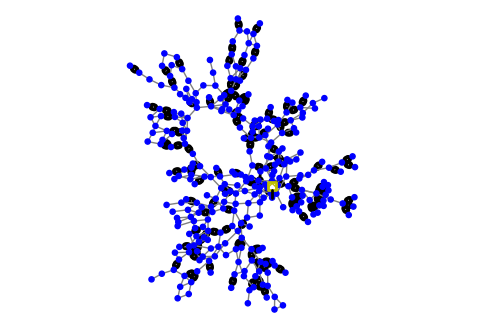

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
ax = pp.plotting.simple_plot(net_real, ax=ax)

## Generate a synthetic grid

### Extract Topology Characteristics from Graph

In [31]:
print("\n[2] Analyzing Reference Topology...")
params = extract_topology_params_from_graph(graph_real)


[2] Analyzing Reference Topology...
Extracting topology parameters...


### PowerGridGenerator

In [32]:
# 3. Generate Synthetic Grid
print("\n[3] Generating Synthetic Clone...")
gen = PowerGridGenerator(seed=53)
synthetic_graph = gen.generate_grid(
    degrees_by_level=params['degrees_by_level'],
    diameters_by_level=params['diameters_by_level'],
    transformer_degrees=params['transformer_degrees'],
    keep_lcc=True
)


[3] Generating Synthetic Clone...
--- Starting Generation for 13 Voltage Levels ---
Generating Level 0...
  -> Level 0 Complete. Nodes: 18, Edges: 14
Generating Level 1...
  -> Level 1 Complete. Nodes: 89, Edges: 91
Generating Level 2...
  -> Level 2 Complete. Nodes: 21, Edges: 19
Generating Level 3...
  -> Level 3 Complete. Nodes: 133, Edges: 167
Generating Level 4...
  -> Level 4 Complete. Nodes: 2, Edges: 0
Generating Level 5...
  -> Level 5 Complete. Nodes: 23, Edges: 16
Generating Level 6...
  -> Level 6 Complete. Nodes: 1, Edges: 0
Generating Level 7...
  -> Level 7 Complete. Nodes: 5, Edges: 0
Generating Level 8...
  -> Level 8 Complete. Nodes: 1, Edges: 0
Generating Level 9...
  -> Level 9 Complete. Nodes: 23, Edges: 0
Generating Level 10...
  -> Level 10 Complete. Nodes: 13, Edges: 9
Generating Level 11...
  -> Level 11 Complete. Nodes: 3, Edges: 0
Generating Level 12...
  -> Level 12 Complete. Nodes: 15, Edges: 0
Generating Transformer Connections...
  -> Connecting Level 0 

### Bus type assignment (optional)

In [33]:
# 4. Allocate Bus Types
print("\n[4] Allocating Bus Types via AIS...")
allocator = BusTypeAllocator(synthetic_graph)
# The allocator uses the graph size to determine target ratios dynamically
bus_types = allocator.allocate(max_iter=50)
nx.set_node_attributes(synthetic_graph, bus_types, name="bus_type")


[4] Allocating Bus Types via AIS...
Starting Bus Type Allocation (N=323, M=431)...
  Target Entropy Score (W*): 2.5909, Std Dev: 0.0243
  Iter 0: Best Error = 0.002093
  Converged at iteration 1. Error: 0.000015 < Criteria: 0.000024


## Analysis

In [34]:
#5. Compare using the Library Module
print("\n[5] Running Comparative Analysis...")
comparator = GraphComparator(
    synth_graph=synthetic_graph, 
    ref_graph=graph_real, 
    synth_label="Synthetic", 
    ref_label="IEEE grid"
)


[5] Running Comparative Analysis...


#### Compare some metric Globally

In [35]:
comparator.print_metric_comparison(title="GLOBAL TOPOLOGY COMPARISON")


GLOBAL TOPOLOGY COMPARISON
            Metric Synthetic IEEE grid
             Nodes       323       300
             Edges       431       409
           Density  0.008288  0.009119
        Connected?       Yes       Yes
    Diameter (LCC)        18        24
Avg Path Len (LCC)    7.6790    9.9353
    Avg Clustering    0.0590    0.0856
      Transitivity    0.0799    0.0960



#### Plot the global node degree distribution for two grids

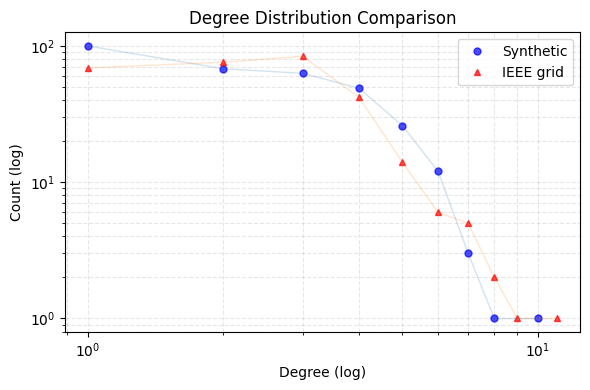

In [36]:
comparator.plot_degree_comparison(log_scale=True, fig_size=(6,4), show_lines=True,)

#### Compare the histograms of node degrees for each voltage level

Plotting Combined Comparison Figure for 13 Levels (Log Scale: False)...


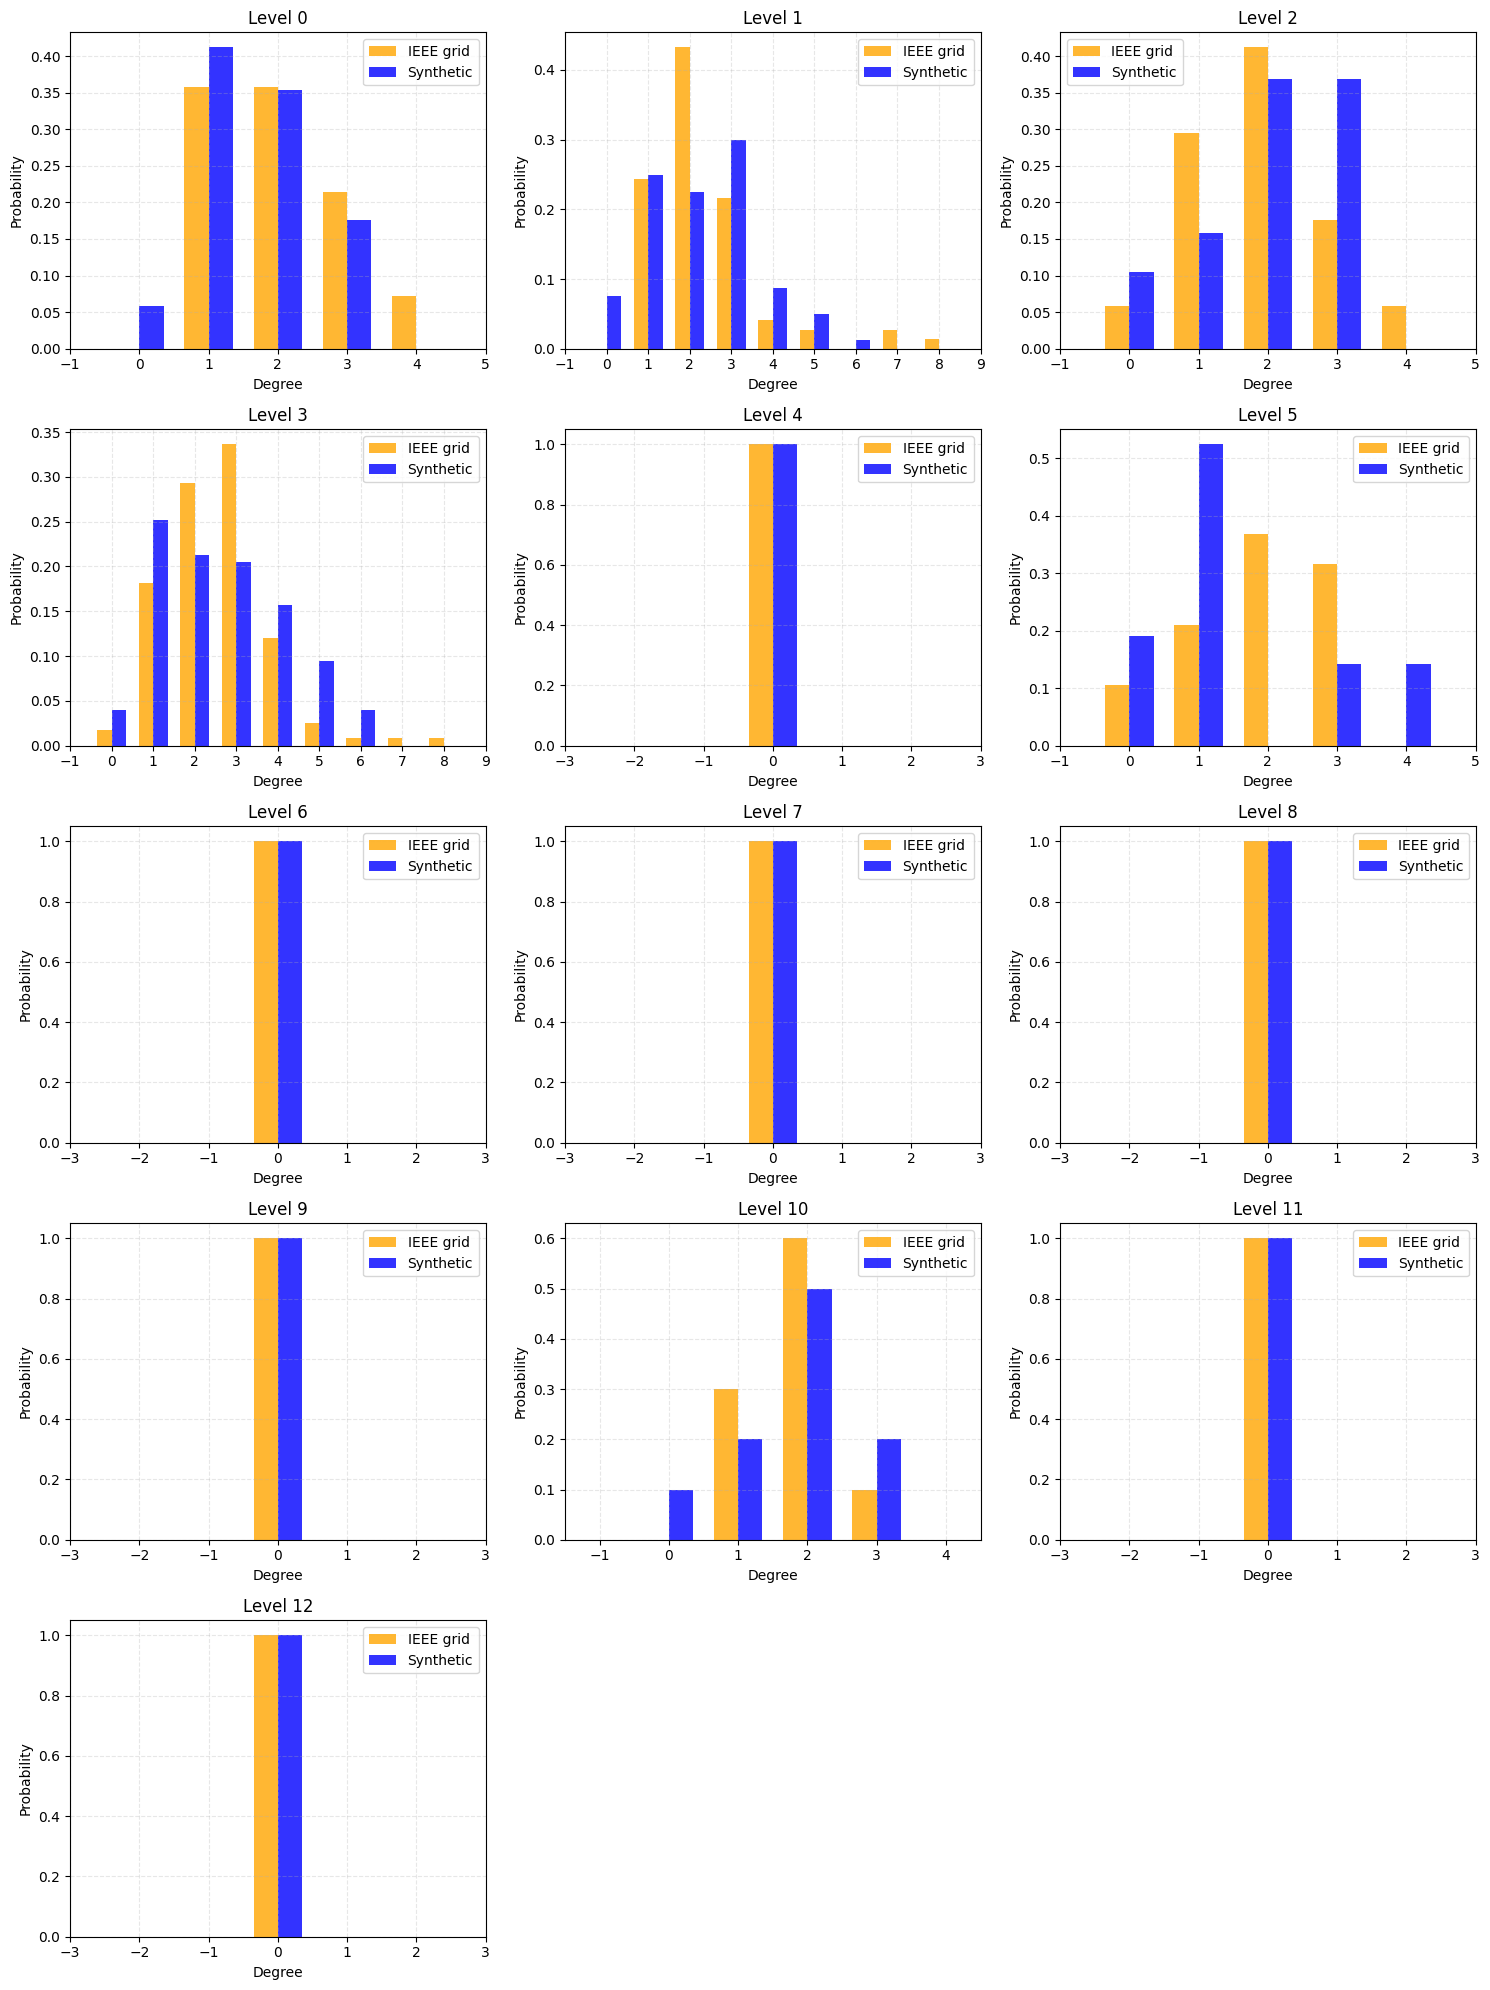

In [37]:
comparator.plot_all_levels_comparison(False)

#### Compare other topology metrics per voltage level

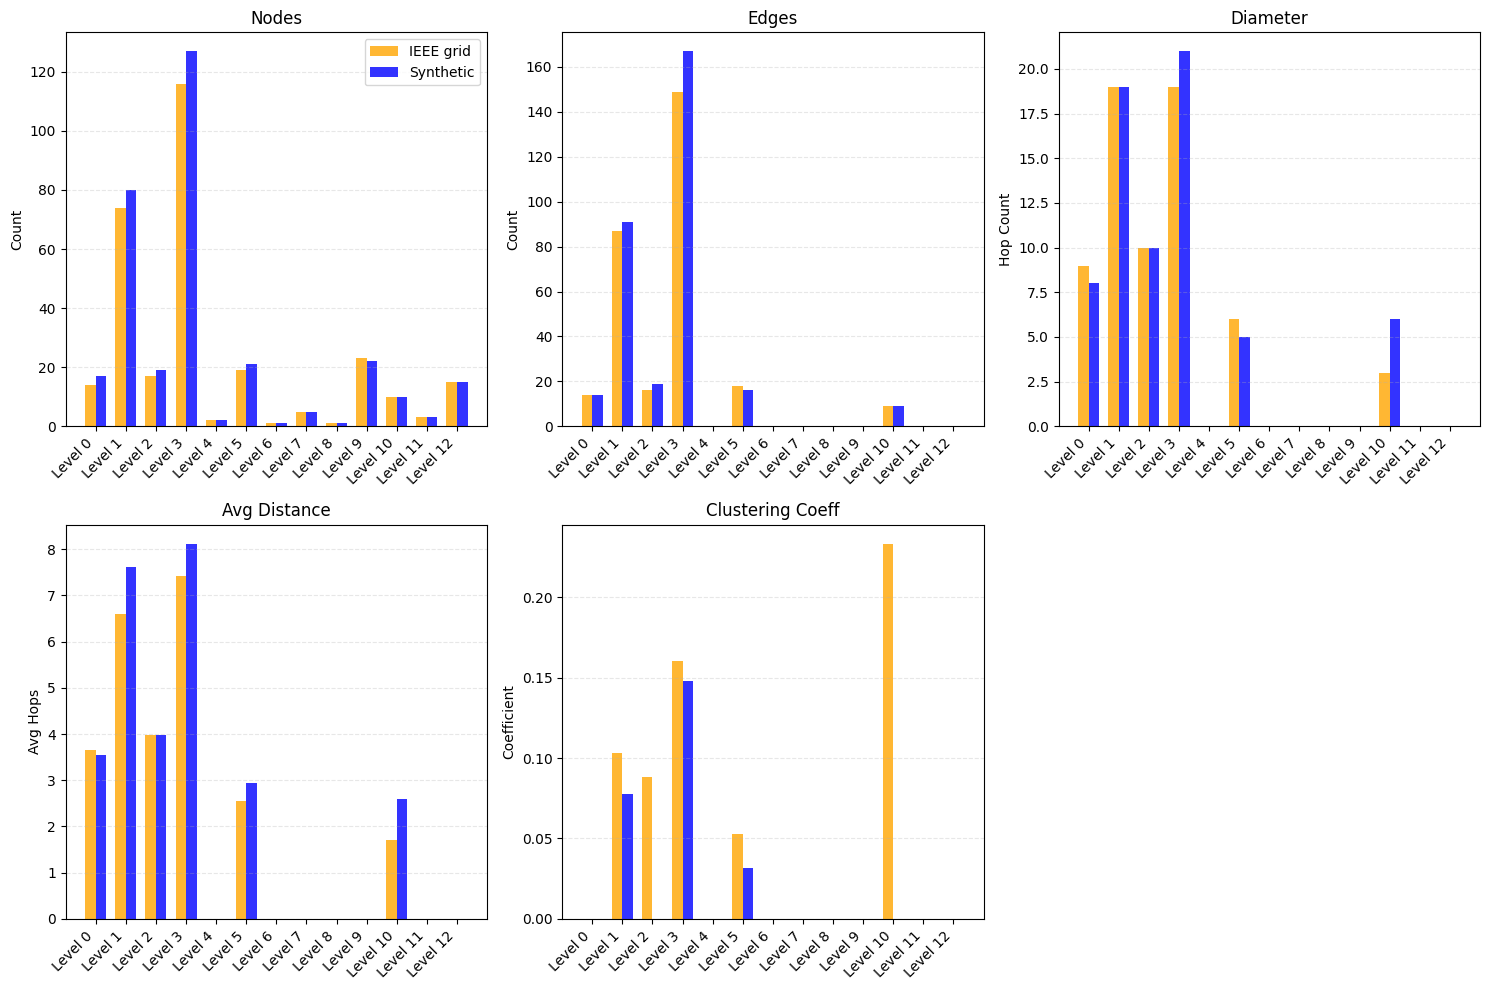

In [38]:
comparator.plot_level_topology_comparison()

## Visualizations

In [39]:
viz = GridVisualizer()

Calculating layout 'kamada_kawai'...


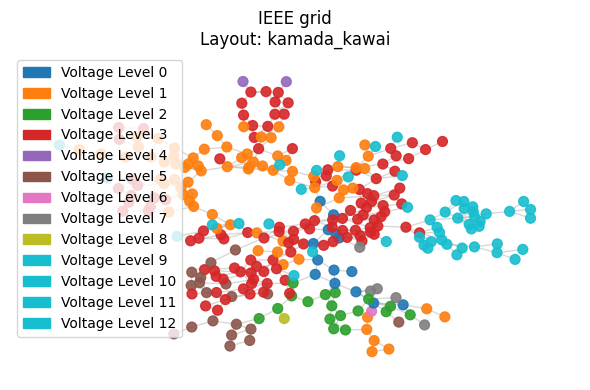

In [40]:
viz.plot_grid(
    graph_real, 
    layout='kamada_kawai',
    title="IEEE grid",
    figsize=(6, 4)
)

Calculating layout 'kamada_kawai'...


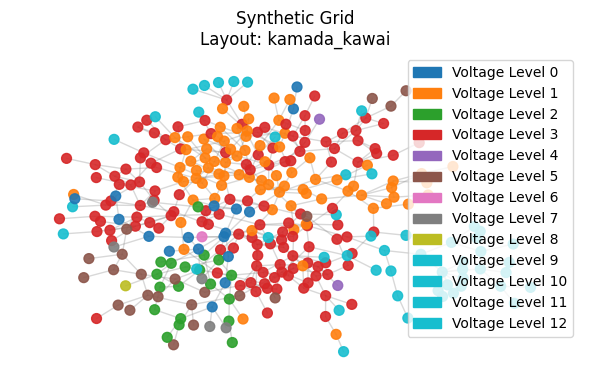

In [41]:
viz.plot_grid(
    synthetic_graph, 
    layout='kamada_kawai',
    title="Synthetic Grid",
    figsize=(6, 4)
)